In [25]:
using Revise

using Amaru

In [26]:
# Mesh generation
bls = [
       Block3D( [0 0 0; 1.0 6.0 1.0], nx=1, ny=10, nz=1),
       BlockInset( [0.5 3 0.5; 0.5 6.0 0.5], curvetype="polyline"),
      ]

msh = Mesh(bls, verbose=true)

# Tagging entities
bar_points  = sort(msh.cells[:lines][:points], by=get_y)
cell_points = msh.cells[:solids][:points]

tag!(bar_points[end], "tip")
tag!(cell_points, "fixed_points")


Mesh generation:
  analyzing 2 block(s)
  3D mesh             
     55 points obtained
     20 cells obtained
     42 faces obtained
     84 surface edges obtained
      4 intersections found
  done.


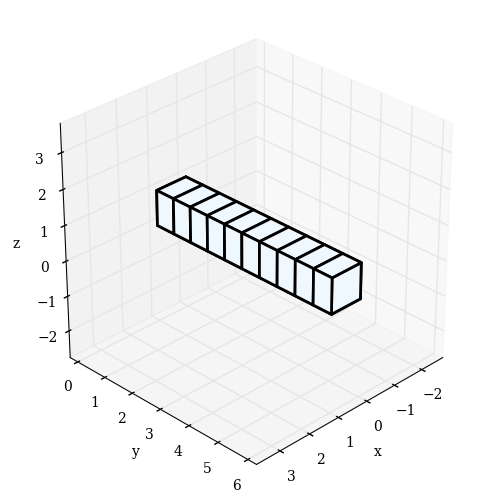

In [27]:
mplot(msh)

In [28]:
# FEM analysis

phi = 30*pi/180; dm=0.15138; c=20.0
mats = [
        MaterialBind(:solids, ElasticSolid(E=24e3, nu=0.2)),
        MaterialBind(:lines, ElasticRod(E=1.e8, A=0.005)),
        MaterialBind(:lines, ElasticRod(E=200e6, A=0.00011)),
        MaterialBind(:joints1D, CEBJoint1D(TauM=12, TauR=3, s1=0.001, s2=0.0011, s3=0.004, alpha=0.5, beta=0.5,
                                           ks=(12/0.001)*5, kn=50000, A=0.005), iptag="joint_ips")
       ]

log_tip     = Logger(:node, "tip")
log_jnt_ip  = Logger(:ip, :(tag=="joint_ips" && y>5.8))
log_jnt_ips = GroupLogger(:ips, "joint_ips", by=get_y)
logs = [ log_tip, log_jnt_ip, log_jnt_ips ]

dom = Domain(msh, mats, logs);


Domain setup:
  3D domain general model      
     55 nodes
     20 elements
     42 faces
     84 edges
      4 materials
      3 loggers
  done.


In [29]:
reset!(dom)
bc1 = BC(:node, "fixed_points", :(ux=0, uy=0, uz=0))
bc2 = BC(:node, "tip", :(uy=+0.005))

solve!(dom, [bc1, bc2], nincs=40, autoinc=true, verbose=true)


FEM analysis:
  unknown dofs: 32
  increment 1 from t=0.0 to t=0.025 (dt=0.025):
    it 1   residue: 7.1487e-01
    it 2   residue: 4.8636e-02
    it 3   residue: 2.0247e-02
    it 4   residue: 8.9860e-03
  increment 2 from t=0.025 to t=0.05 (dt=0.025):
    it 1   residue: 2.2445e-01
    it 2   residue: 6.3759e-02
    it 3   residue: 2.3391e-02
    it 4   residue: 7.6070e-03
  increment 3 from t=0.05 to t=0.075 (dt=0.025):
    it 1   residue: 1.5242e-01
    it 2   residue: 4.0503e-02
    it 3   residue: 1.2521e-02
    it 4   residue: 3.5846e-03
  increment 4 from t=0.075 to t=0.1 (dt=0.025):
    it 1   residue: 1.2248e-01
    it 2   residue: 3.0321e-02
    it 3   residue: 8.3732e-03
  increment 5 from t=0.1 to t=0.125 (dt=0.025):
    it 1   residue: 1.0539e-01
    it 2   residue: 2.4988e-02
    it 3   residue: 6.3241e-03
  increment 6 from t=0.125 to t=0.15 (dt=0.025):
    it 1   residue: 9.3841e-02
    it 2   residue: 2.1126e-02
    it 3   residue: 4.9768e-03
  increment 7 from t=0.15

true

In [30]:
length(log_jnt_ips.book.tables)

41

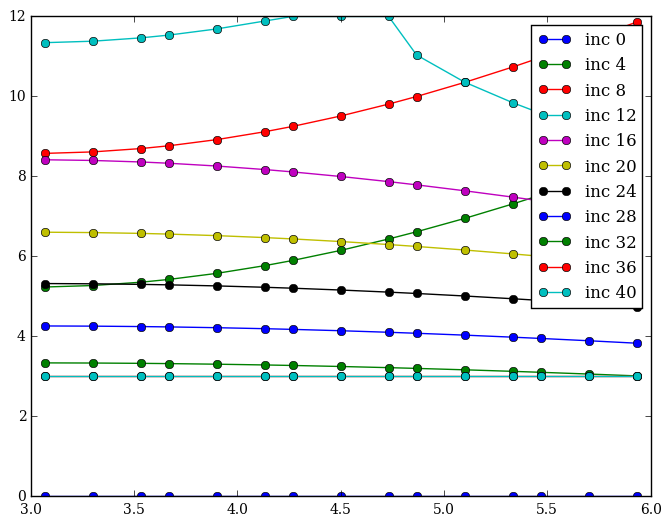

In [31]:
using PyPlot
rc("font", family="serif", size=10)

for i=0:4:40
    tab = log_jnt_ips.book.tables[i+1]
    plot(tab[:y], tab[:tau], marker="o", label="inc $i")
end
legend();


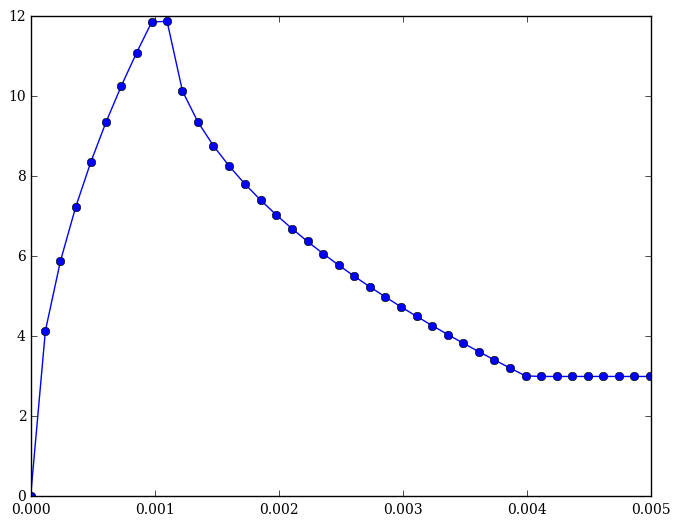

In [32]:
using PyPlot
tab = log_jnt_ip.table
plot(tab[:ur], tab[:tau], marker="o");


In [33]:
reset!(dom)
bc1 = BC(:node, "fixed_points", :(ux=0, uy=0, uz=0))
bc2 = BC(:node, "tip", :(uy=+0.0003))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = BC(:node, "tip", :(uy=-0.0001))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = BC(:node, "tip", :(uy=+0.0006))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = BC(:node, "tip", :(uy=-0.0006))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = BC(:node, "tip", :(uy=+0.005))
solve!(dom, [bc1, bc2], nincs=30, autoinc=true, verbose=true)


FEM analysis:
  unknown dofs: 32
  increment 1 from t=0.0 to t=0.1 (dt=0.1):
    it 1   residue: 8.2054e-02
    it 2   residue: 1.1611e-02
    it 3   residue: 5.2704e-03
  increment 2 from t=0.1 to t=0.2 (dt=0.1):
    it 1   residue: 1.0423e-01
    it 2   residue: 1.8570e-02
    it 3   residue: 1.1566e-02
    it 4   residue: 5.7570e-03
  increment 3 from t=0.2 to t=0.3 (dt=0.1):
    it 1   residue: 7.1183e-02
    it 2   residue: 1.7820e-02
    it 3   residue: 9.1686e-03
  increment 4 from t=0.3 to t=0.4 (dt=0.1):
    it 1   residue: 5.7490e-02
    it 2   residue: 1.5975e-02
    it 3   residue: 7.3276e-03
  increment 5 from t=0.4 to t=0.5 (dt=0.1):
    it 1   residue: 4.9496e-02
    it 2   residue: 1.4013e-02
    it 3   residue: 5.9428e-03
  increment 6 from t=0.5 to t=0.6 (dt=0.1):
    it 1   residue: 4.4155e-02
    it 2   residue: 1.2514e-02
    it 3   residue: 4.9854e-03
  increment 7 from t=0.6 to t=0.7 (dt=0.1):
    it 1   residue: 4.0264e-02
    it 2   residue: 1.1338e-02
    it 3

    it 2   residue: 2.6019e-02
    it 3   residue: 9.7692e-03
  increment 11 from t=0.3081333333 to t=0.3414333333 (dt=0.0333):
    it 1   residue: 4.7424e-01
    it 2   residue: 7.4585e-02
    it 3   residue: 2.6017e-02
    it 4   residue: 6.9782e-03
  increment 12 from t=0.3414333333 to t=0.3747333333 (dt=0.0333):
    it 1   residue: 1.4569e-01
    it 2   residue: 2.8414e-02
    it 3   residue: 6.1277e-03
  increment 13 from t=0.3747333333 to t=0.4080333333 (dt=0.0333):
    it 1   residue: 1.0372e-01
    it 2   residue: 1.7985e-02
    it 3   residue: 3.0952e-03
  increment 14 from t=0.4080333333 to t=0.4413333333 (dt=0.0333):
    it 1   residue: 7.9299e-02
    it 2   residue: 1.2481e-02
    it 3   residue: 1.8436e-03
  increment 15 from t=0.4413333333 to t=0.4746333333 (dt=0.0333):
    it 1   residue: 6.6215e-02
    it 2   residue: 9.5335e-03
  increment 16 from t=0.4746333333 to t=0.5079333333 (dt=0.0333):
    it 1   residue: 5.5584e-02
    it 2   residue: 7.4719e-03
  increment 17 

true

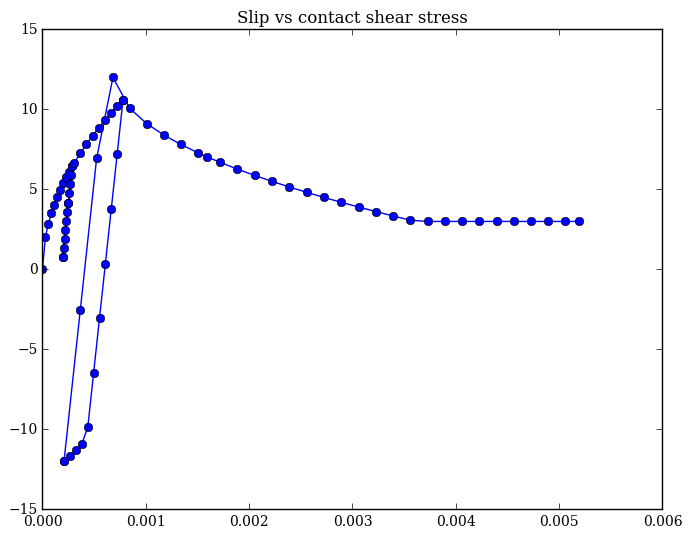

PyObject <matplotlib.text.Text object at 0x7f532dea40d0>

In [34]:
using PyPlot
tab = log_jnt_ip.table
plot(tab[:ur], tab[:tau], marker="o");
title("Slip vs contact shear stress")